In [93]:
import numpy as np
import json
import os
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

mi.set_variant("llvm_ad_rgb_double")

In [94]:
def relative_diff(a, b):
    return (a - b) / b

def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

In [95]:
wind_speed = 5
wind_azimuth = 0
data_file = f'data/data_{wind_speed}ms.json'
data = None

# Load data
with open(data_file, 'r') as f:
    data = json.load(f)

reference_data = {}

# Loop over entries in data
for entry in data:
    # Cut 'reflectance_' and '.json' from start and end of filename
    incoming_zenith = entry[12:-5]
    incoming_data = data[entry]
   
    reference_data[incoming_zenith] = incoming_data


In [96]:
# Get a random entry from the reference data
#random_entry = list(reference_data.items())[np.random.randint(0, len(reference_data))]
random_entry = list(reference_data.items())[1]
random_entry_key = random_entry[0]
random_entry_data = random_entry[1]
ref_incoming_zenith = random_entry[0] 
ref_reflectances = random_entry[1]
ref_reflectance_data = []

# Loop over reflectances
for key in ref_reflectances:
    ref_reflectance_data.append(ref_reflectances[key])

# Incoming zenith to float
ref_incoming_zenith = float(ref_incoming_zenith)

In [97]:
incoming_zeniths = list(reference_data.keys())

# Construct BRDF test
outgoing_azimuth = 180
bsdf = mi.load_dict({
    'type': 'oceanic_legacy',
    'wavelength': 0.5,
    'wind_speed': wind_speed,
    'wind_direction': wind_azimuth,
    'chlorinity': 19,
    'pigmentation': 0.3
})

computed_data = {}

index = 0
max_index = len(incoming_zeniths)
for incoming_zenith in incoming_zeniths:
    # Create a dummy surface interaction to use for the evaluation of the BSDF
    si = dr.zeros(mi.SurfaceInteraction3f)

    incoming_zenith = float(incoming_zenith)

    # Angle stuff
    si.wi = sph_to_eucl(incoming_zenith, dr.deg2rad(0))
    zeniths_o, azimuths_o = dr.meshgrid(
        dr.linspace(mi.Float, np.deg2rad(1), np.deg2rad(89), len(ref_reflectances)),
        dr.linspace(mi.Float, 0, np.deg2rad(outgoing_azimuth), 1)
    )
    wo = sph_to_eucl(zeniths_o, azimuths_o)

    # Evaluate the BSDF
    brdf_values = bsdf.eval(mi.BSDFContext(), si, wo)
    brdf_np = np.array(brdf_values)
    brdf_data = brdf_np[:,0]

    computed_data[incoming_zenith] = brdf_data

    index += 1
    print(f'Progress: {index}/{max_index}')

Progress: 1/360
Progress: 2/360
Progress: 3/360
Progress: 4/360
Progress: 5/360
Progress: 6/360
Progress: 7/360
Progress: 8/360
Progress: 9/360
Progress: 10/360
Progress: 11/360
Progress: 12/360
Progress: 13/360
Progress: 14/360
Progress: 15/360
Progress: 16/360
Progress: 17/360
Progress: 18/360
Progress: 19/360
Progress: 20/360
Progress: 21/360
Progress: 22/360
Progress: 23/360
Progress: 24/360
Progress: 25/360
Progress: 26/360
Progress: 27/360
Progress: 28/360
Progress: 29/360
Progress: 30/360
Progress: 31/360
Progress: 32/360
Progress: 33/360
Progress: 34/360
Progress: 35/360
Progress: 36/360
Progress: 37/360
Progress: 38/360
Progress: 39/360
Progress: 40/360
Progress: 41/360
Progress: 42/360
Progress: 43/360
Progress: 44/360
Progress: 45/360
Progress: 46/360
Progress: 47/360
Progress: 48/360
Progress: 49/360
Progress: 50/360
Progress: 51/360
Progress: 52/360
Progress: 53/360
Progress: 54/360
Progress: 55/360
Progress: 56/360
Progress: 57/360
Progress: 58/360
Progress: 59/360
Progre

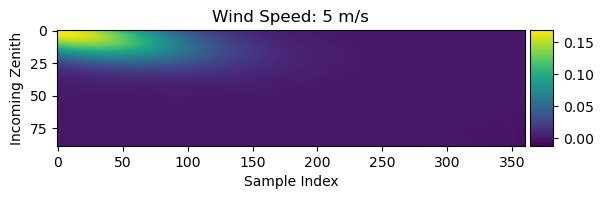

In [98]:
# 2D plot of the reference data
fig, ax = plt.subplots()

data_array = np.zeros((len(reference_data), len(random_entry_data)))
index = 0
for entry in reference_data:
    entry_data = reference_data[entry].values()
    entry_data_array = np.array([float(i) for i in entry_data])

    # Set the data as the row
    data_array[index] = entry_data_array

    index += 1

# Plot the data
im = ax.imshow(data_array.T, cmap='viridis')

# Create colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')

# Set labels
ax.set_xlabel('s')
ax.set_ylabel('Incoming Zenith')
ax.set_title(f'Wind Speed: {wind_speed} m/s')

plt.show()

In [99]:
# Diagnostics
min_val = np.min(data_array)
max_val = np.max(data_array)
mean_val = np.mean(data_array)

min_val_index = np.unravel_index(np.argmin(data_array, axis=None), data_array.shape)
max_val_index = np.unravel_index(np.argmax(data_array, axis=None), data_array.shape)

print(f'Minimum value: {min_val} (Incoming zenith: {min_val_index[0]}, Reflectance: {min_val_index[1]})')
print(f'Maximum value: {max_val} (Incoming zenith: {max_val_index[0]}, Reflectance: {max_val_index[1]})')
print(f'Mean value: {mean_val}')

Minimum value: -0.0116891 (Incoming zenith: 359, Reflectance: 88)
Maximum value: 0.1689848 (Incoming zenith: 0, Reflectance: 0)
Mean value: 0.01021154651997503
